In [2]:
import torch
import numpy as np

In [3]:
print(torch.tensor([[1, 2], [3, 4]]))

tensor([[1, 2],
        [3, 4]])


In [4]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (1.0))
])

In [5]:
from torchvision.datasets import MNIST
import requests
import os

download_root = '../pytorch_txtbook/data/'

train_data = MNIST(download_root, transform=mnist_transform,
                    train=True, download=True)
valid_data = MNIST(download_root, transform=mnist_transform,
                    train=False, download=True)
test_data = MNIST(download_root, transform=mnist_transform,
                    train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../pytorch_txtbook/data/MNIST/raw/train-images-idx3-ubyte.gz to ../pytorch_txtbook/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../pytorch_txtbook/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../pytorch_txtbook/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../pytorch_txtbook/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../pytorch_txtbook/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../pytorch_txtbook/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../pytorch_txtbook/data/MNIST/raw



In [6]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=30, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(in_features=30*5*5, out_features=10, bias=True),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.shape[0], -1)
        x = self.layer3(x)

        return x

model = MLP()

print('printing children\n----------------------------')
print(list(model.children()))
print('printing modules\n-----------------------------')
print(list(model.modules()))

printing children
----------------------------
[Sequential(
  (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Sequential(
  (0): Conv2d(64, 30, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Sequential(
  (0): Linear(in_features=750, out_features=10, bias=True)
  (1): ReLU(inplace=True)
)]
printing modules
-----------------------------
[MLP(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_

In [7]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [8]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform ={
            'train': transforms.Compose([           # transforms.Compose() 이미지 변형할 수 있는 방식들의 묶음
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),     # RandomResizeCrop 이미지를 주어진 크기로 자름, scale은 원본 이미지를 임의의 크기(0.5-1.0 즉, 50%-100%)만큼 무작위로 자름
                transforms.RandomHorizontalFlip(),  # RandomHorizontalFlip 주어진 확률(default=0.5)로 수평 반전(위아래 뒤집음)
                transforms.ToTensor(),              # ToTensor 파이토치, torchvision은 이미지를 읽을 때 이미지 범위[0, 255] 차원(height X width X channel)
                                                    # 효율적 연산을 위해 픽셀 값의 범위를 [0.0, 1.0]으로 변환해야 하고 차원 순서도 (C x H x W)로 바뀌는데 이를 ToTensor가 연산해 줌
                transforms.Normalize(mean, std)     # mean, std (R, G, B)값이 들어감, 때에 따라 BGR된 이미지가 있을 수 있으니 주의  
            ]),
            'valid': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def  __call__(self, img, phase):
        return self.data_transform[phase](img)

In [9]:
data_path = '/home/hoon/nia_retina/retina_img'

file_list = os.listdir(data_path + '/retina_0')
file_list

['0_1.2.410.200013.1.300.1.20190930110941869.140.dcm_10000147.png',
 '1000_1.2.410.200013.1.300.1.20190307090357957.87.dcm_5133643.png',
 '1002_1.2.410.200013.1.300.1.20200213080240755.29.dcm_5133643.png',
 '1001_1.2.410.200013.1.300.1.20200213080241082.30.dcm_5133643.png',
 '1004_1.2.276.0.75.2.1.20.0.3.190823155354699.1195760.4081.dcm_5135681.png',
 '1005_1.2.124.113532.10.200.10.52.20140421.121721.25161046.1.1.3141.dcm_5150479.png',
 '1006_1.2.124.113532.10.200.10.52.20140421.121721.25161046.1.2.3153.dcm_5150479.png',
 '1012_1.2.410.100011.1.0.101.0.012.20170119.101310.1.1.1357.dcm_5166607.png',
 '100_1.2.410.200013.1.300.1.20201207091220875.54.dcm_10215840.png',
 '1013_1.2.410.100011.1.0.101.0.012.20170119.101310.1.2.1409.dcm_5166607.png',
 '1017_1.2.840.113619.2.182.140128351643084.1470272356.2557596.1.2.0509.dcm_5166607.png',
 '1018_1.2.840.113619.2.182.140128351643084.1472689819.2828376.1.2.3942.dcm_5166607.png',
 '1019_1.2.840.113619.2.182.140128351643084.1472689819.2828376.1.1

In [10]:
from torchvision import transforms, datasets

data_path = '/home/hoon/nia_retina/retina_img'
retina_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),   # image resizing
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # correct calculation should be done!!
                                ]))

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# train:validation:test = 8:1:1
random_seed = 42

train_idx, tmp_idx = train_test_split(list(range(len(retina_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(retina_dataset, train_idx)
tmp_dataset = Subset(retina_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.2, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test'] = Subset(tmp_dataset, test_idx)

In [12]:
train_idx

[6,
 789,
 1049,
 837,
 661,
 332,
 528,
 956,
 215,
 970,
 605,
 830,
 328,
 428,
 743,
 1090,
 974,
 462,
 903,
 1012,
 962,
 874,
 723,
 265,
 704,
 25,
 299,
 294,
 990,
 365,
 106,
 617,
 55,
 1060,
 213,
 120,
 701,
 1051,
 72,
 614,
 1015,
 292,
 765,
 567,
 430,
 298,
 342,
 755,
 864,
 902,
 377,
 493,
 905,
 60,
 447,
 92,
 716,
 277,
 811,
 1033,
 411,
 597,
 182,
 531,
 308,
 110,
 958,
 585,
 1034,
 892,
 925,
 945,
 261,
 336,
 689,
 961,
 852,
 137,
 583,
 352,
 876,
 485,
 649,
 626,
 29,
 165,
 248,
 381,
 359,
 327,
 848,
 745,
 869,
 525,
 656,
 570,
 65,
 946,
 964,
 866,
 254,
 780,
 312,
 1007,
 221,
 235,
 423,
 589,
 305,
 351,
 650,
 1040,
 249,
 786,
 478,
 71,
 94,
 33,
 1043,
 259,
 204,
 628,
 1005,
 425,
 77,
 84,
 813,
 82,
 481,
 504,
 660,
 718,
 453,
 523,
 350,
 697,
 5,
 310,
 536,
 104,
 97,
 803,
 993,
 314,
 497,
 494,
 1010,
 281,
 611,
 266,
 548,
 238,
 575,
 145,
 1019,
 464,
 845,
 118,
 506,
 499,
 250,
 613,
 285,
 533,
 9,
 486,
 196,
 711

In [13]:
batch_size = 128

dataloaders, batch_num = {}, {}

dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                                 batch_size=batch_size, shuffle=True,
                                                 num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                                 batch_size=batch_size, shuffle=False,
                                                 num_workers=4)
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'],
                                                 batch_size=batch_size, shuffle=False,
                                                 num_workers=4)

batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])                                                 

In [14]:
import torchvision

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)
    
num_img_show = 5

class_names = {'0': 'Normal',
              '1': 'ASD'}

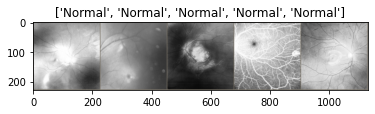

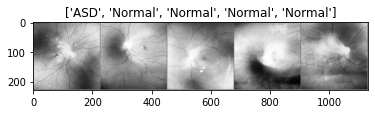

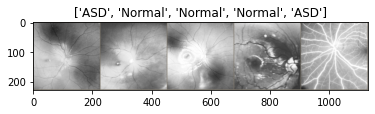

In [15]:
# train
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_img_show])
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_img_show]])

# valid
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_img_show])
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_img_show]])

#test
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_img_show])
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_img_show]])

In [16]:
# 모델 정의

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.cnn1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=0
        )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=0
        )
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1) # fc(fully connected) layer에 데이터 전달을 위해 데이터 형태를 1차원으로 바꿈
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)

        return out

In [17]:
model = LeNet()
model

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)

In [24]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same